In [21]:
try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random

In [22]:
print(tf.__version__)

2.3.1


In [23]:
# Function used to make this notebook's output stable across runs.
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Method to plot the Perceptron's decision boundary.
def plot_decision_boundary(classifier, X, y, title):    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    XX_ = np.c_[xx.ravel(), yy.ravel()]
        
    Z = classifier.predict(XX_)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(5, 5))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('$x_1$',fontsize=20)
    plt.ylabel('$x_2$',fontsize=20)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)    

    plt.show()
    
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot
    
class MyMLP():
    
    def __init__(self, filename):
        self.filename = filename

    def predict(self, X_):
        with tf.Session() as sess:
            saver.restore(sess, self.filename)
            res = sess.run(softmax, feed_dict={X : X_})
            Z = np.zeros((X_.shape[0]),)
            inc = 0
            for element in res:
                Z[inc] = np.argmax(element)
                inc += 1
        return Z

def createLogDir(root_logdir="./ex7_logs"):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)
    return logdir

In [24]:
from sklearn.datasets import make_circles 
seed = 21
random.seed(seed)
N = 1000
X_, y_ = make_circles(n_samples=N, random_state=42, noise=0.1, factor=0.2)

In [25]:
logdir = createLogDir()

print('LOG dir: ',logdir)

LOG dir:  ./ex7_logs/run-20201128172823/


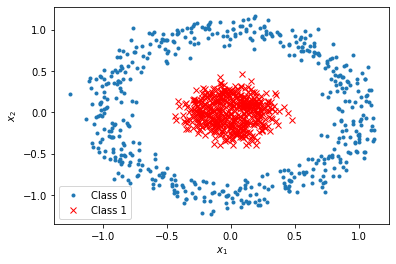

In [26]:
idx0 = np.argwhere(y_ == 0)
idx1 = np.argwhere(y_ == 1)


plt.plot(X_[idx0,0], X_[idx0,1], '.', label='Class 0')
plt.plot(X_[idx1,0], X_[idx1,1], 'rx', label='Class 1')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [27]:
reset_graph()

num_epoch = 30000
learning_rate = 0.1

X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

W_ = tf.Variable(tf.random_uniform([2, 4], -2.0, 5.0), name="W_")
W_1 = tf.Variable(tf.random_uniform([4, 2], -2.0, 5.0), name="W_1")

B_ = tf.Variable(tf.random_uniform(shape=[4], minval=-2.0, maxval=5.0), name='B_')
B_1= tf.Variable(tf.random_uniform(shape=[2], minval=-2.0, maxval=5.0), name='B_1')


# Hidden layer and output layer.
with tf.name_scope('hidden'):
    logits = tf.matmul(tf.sigmoid(tf.matmul(X, W_) + B_) , W_1)+ B_1
    softmax = tf.nn.softmax(logits)

# Error estimation
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

saver = tf.train.Saver()

loss_summary = tf.summary.scalar('loss', loss)

acc_summary = tf.summary.scalar('accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())



In [28]:
sess = tf.Session()
sess.run(init)

loss_vec_gd = []
epoch_vec_gd = []
for i in range(0, num_epoch):
    error = sess.run(training_op, feed_dict={X: X_, y: y_})
    if(i % 100) == 0:
        loss_value = sess.run(loss, feed_dict={X: X_, y: y_})
        acc = sess.run(accuracy, feed_dict={X: X_, y: y_})
        print('Epoch: ' + str(i) + ' - Error: ' + str( loss_value ) + ' - Acc: ' + str(acc))
        loss_vec_gd.append(loss_value)
        epoch_vec_gd.append(i)
        save_path = saver.save(sess, logdir+'three_classes_model_gd_opt.ckpt')
    loss_str = sess.run(loss_summary, feed_dict={X: X_, y: y_})  
    file_writer.add_summary(loss_str, i)
    acc_str = sess.run(acc_summary, feed_dict={X: X_, y: y_})
    file_writer.add_summary(acc_str, i)
    
for el in sess.run(softmax, feed_dict={X: X_}):
    print('    ',el)
    
save_path = saver.save(sess, logdir+'three_classes_gd_optimizer_final.ckpt')
    
sess.close()
 
print ("Training Complete")

Epoch: 0 - Error: 1.440927 - Acc: 0.5
Epoch: 100 - Error: 0.570281 - Acc: 0.826
Epoch: 200 - Error: 0.48818755 - Acc: 0.878
Epoch: 300 - Error: 0.4426679 - Acc: 0.871
Epoch: 400 - Error: 0.41430718 - Acc: 0.871
Epoch: 500 - Error: 0.39465478 - Acc: 0.869
Epoch: 600 - Error: 0.38007572 - Acc: 0.872
Epoch: 700 - Error: 0.36882827 - Acc: 0.872
Epoch: 800 - Error: 0.35992804 - Acc: 0.873
Epoch: 900 - Error: 0.35273123 - Acc: 0.874
Epoch: 1000 - Error: 0.34677172 - Acc: 0.875
Epoch: 1100 - Error: 0.3416839 - Acc: 0.878
Epoch: 1200 - Error: 0.33715796 - Acc: 0.877
Epoch: 1300 - Error: 0.3329074 - Acc: 0.88
Epoch: 1400 - Error: 0.32864305 - Acc: 0.883
Epoch: 1500 - Error: 0.3240521 - Acc: 0.884
Epoch: 1600 - Error: 0.31878456 - Acc: 0.884
Epoch: 1700 - Error: 0.3124541 - Acc: 0.884
Epoch: 1800 - Error: 0.30465955 - Acc: 0.885
Epoch: 1900 - Error: 0.29503122 - Acc: 0.887
Epoch: 2000 - Error: 0.28329462 - Acc: 0.888
Epoch: 2100 - Error: 0.2693385 - Acc: 0.893
Epoch: 2200 - Error: 0.25329003 - A

Epoch: 18500 - Error: 0.008078426 - Acc: 1.0
Epoch: 18600 - Error: 0.00803279 - Acc: 1.0
Epoch: 18700 - Error: 0.007987685 - Acc: 1.0
Epoch: 18800 - Error: 0.007943121 - Acc: 1.0
Epoch: 18900 - Error: 0.007899089 - Acc: 1.0
Epoch: 19000 - Error: 0.00785554 - Acc: 1.0
Epoch: 19100 - Error: 0.007812496 - Acc: 1.0
Epoch: 19200 - Error: 0.007769962 - Acc: 1.0
Epoch: 19300 - Error: 0.0077278954 - Acc: 1.0
Epoch: 19400 - Error: 0.007686312 - Acc: 1.0
Epoch: 19500 - Error: 0.0076452014 - Acc: 1.0
Epoch: 19600 - Error: 0.007604539 - Acc: 1.0
Epoch: 19700 - Error: 0.007564329 - Acc: 1.0
Epoch: 19800 - Error: 0.0075246003 - Acc: 1.0
Epoch: 19900 - Error: 0.0074852486 - Acc: 1.0
Epoch: 20000 - Error: 0.007446352 - Acc: 1.0
Epoch: 20100 - Error: 0.0074079 - Acc: 1.0
Epoch: 20200 - Error: 0.0073698587 - Acc: 1.0
Epoch: 20300 - Error: 0.0073321983 - Acc: 1.0
Epoch: 20400 - Error: 0.0072949515 - Acc: 1.0
Epoch: 20500 - Error: 0.0072581307 - Acc: 1.0
Epoch: 20600 - Error: 0.0072216676 - Acc: 1.0
Epoch

     [0.9948177  0.00518229]
     [9.999913e-01 8.741943e-06]
     [0.9903964  0.00960358]
     [0.9970969  0.00290307]
     [0.00114491 0.9988551 ]
     [0.9988463  0.00115369]
     [0.9869739  0.01302609]
     [0.9978022  0.00219776]
     [0.00251565 0.9974843 ]
     [0.9957424  0.00425764]
     [0.99405116 0.00594888]
     [0.00156047 0.9984395 ]
     [0.00498082 0.9950192 ]
     [0.0038623 0.9961377]
     [0.00259153 0.99740845]
     [0.00302508 0.99697495]
     [0.00152157 0.9984785 ]
     [9.9972624e-01 2.7378276e-04]
     [0.99092495 0.00907497]
     [0.9949604  0.00503953]
     [0.00100279 0.9989973 ]
     [0.99733514 0.00266481]
     [0.9975337  0.00246634]
     [0.9943615  0.00563848]
     [0.99510574 0.00489426]
     [0.99769837 0.00230168]
     [0.02872119 0.97127885]
     [0.0020914 0.9979086]
     [0.00414371 0.9958562 ]
     [9.9992466e-01 7.5358868e-05]
     [0.99209 0.00791]
     [0.99428844 0.00571152]
     [0.99825114 0.0017489 ]
     [0.990274 0.009726]
     [0.0022

     [0.01516116 0.98483884]
     [8.9546118e-04 9.9910456e-01]
     [0.99711263 0.00288737]
     [0.00234366 0.99765635]
     [0.00194792 0.9980521 ]
     [0.0028117  0.99718827]
     [0.00165126 0.9983487 ]
     [0.99166065 0.00833935]
     [0.00164602 0.99835396]
     [0.00314049 0.99685955]
     [0.99753296 0.00246701]
     [0.00120932 0.9987907 ]
     [0.00105515 0.9989448 ]
     [0.99754494 0.00245508]
     [0.997735   0.00226502]
     [0.00804094 0.9919591 ]
     [0.00365181 0.9963482 ]
     [0.00114983 0.9988501 ]
     [0.9970758  0.00292424]
     [0.99711275 0.00288729]
     [0.99613625 0.00386373]
     [9.9995589e-01 4.4092838e-05]
     [0.99534297 0.00465708]
     [0.9981285  0.00187158]
     [9.177269e-04 9.990822e-01]
     [0.99488974 0.00511029]
     [0.99460936 0.00539069]
     [0.01736619 0.98263377]
     [0.99424475 0.0057552 ]
     [0.997436   0.00256409]
     [0.9941993  0.00580069]
     [0.00370542 0.99629456]
     [0.99829525 0.00170479]
     [0.00821862 0.9917814 

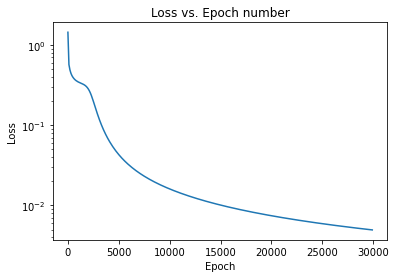

In [29]:
plt.plot(epoch_vec_gd, loss_vec_gd)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

In [30]:
# Calculate and return the accuracy on the test data
with tf.Session() as sess:
    saver.restore(sess, logdir+"three_classes_gd_optimizer_final.ckpt")
    acc = sess.run(accuracy, feed_dict={X: X_, y: y_})

print('Gradient Descent Optimizer accuracy: %1.4f' % (acc))

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128172823/three_classes_gd_optimizer_final.ckpt
Gradient Descent Optimizer accuracy: 1.0000


INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128172823/three_classes_gd_optimizer_final.ckpt


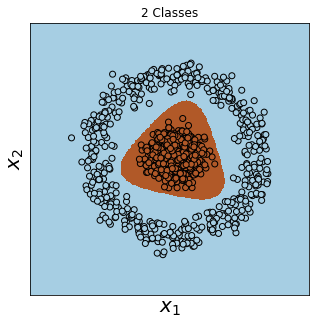

In [31]:
filenameGD = logdir+"three_classes_gd_optimizer_final.ckpt"

clf = MyMLP(filenameGD)

plot_decision_boundary(clf, X_, y_, '2 Classes')

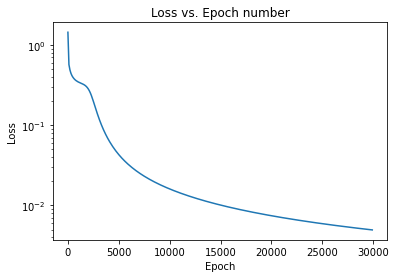

In [32]:
plt.plot(epoch_vec_gd, loss_vec_gd)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128172823/three_classes_gd_optimizer_final.ckpt


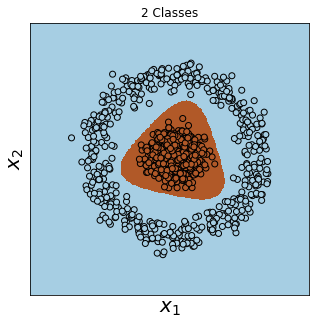

In [34]:
filenameGD = logdir+"three_classes_gd_optimizer_final.ckpt"

clf = MyMLP(filenameGD)

plot_decision_boundary(clf, X_, y_, '2 Classes')

In [35]:
reset_graph()

num_epoch = 30000
learning_rate = 0.1

X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

W_ = tf.Variable(tf.random_uniform([2, 4], -2.0, 5.0), name="W_")
W_1 = tf.Variable(tf.random_uniform([4, 2], -2.0, 5.0), name="W_1")

B_ = tf.Variable(tf.random_uniform(shape=[4], minval=-2.0, maxval=5.0), name='B_')
B_1= tf.Variable(tf.random_uniform(shape=[2], minval=-2.0, maxval=5.0), name='B_1')


# Hidden layer and output layer.
with tf.name_scope('hidden'):
    logits = tf.matmul(tf.sigmoid(tf.matmul(X, W_) + B_) , W_1)+ B_1
    softmax = tf.nn.softmax(logits)

# Error estimation
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

saver = tf.train.Saver()

loss_summary = tf.summary.scalar('loss', loss)

acc_summary = tf.summary.scalar('accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())


In [36]:
sess = tf.Session()
sess.run(init)

loss_vec_adam = []
epoch_vec_adam = []
for i in range(0, num_epoch):
    error = sess.run(training_op, feed_dict={X: X_, y: y_})
    if(i % 100) == 0:
        loss_value = sess.run(loss, feed_dict={X: X_, y: y_})
        acc = sess.run(accuracy, feed_dict={X: X_, y: y_})
        print('Epoch: ' + str(i) + ' - Error: ' + str( loss_value ) + ' - Acc: ' + str(acc))
        loss_vec_adam.append(loss_value)
        epoch_vec_adam.append(i)
        save_path = saver.save(sess, logdir+'three_classes_adam_optimizer_final.ckpt')
    loss_str = sess.run(loss_summary, feed_dict={X: X_, y: y_})  
    file_writer.add_summary(loss_str, i)
    acc_str = sess.run(acc_summary, feed_dict={X: X_, y: y_})
    file_writer.add_summary(acc_str, i)

for el in sess.run(softmax, feed_dict={X: X_}):
    print('    ',el)
    
save_path = saver.save(sess, logdir+'three_classes_adam_optimizer_final.ckpt')
    
sess.close()
 
print ("Training Complete")

Epoch: 0 - Error: 1.196638 - Acc: 0.497
Epoch: 100 - Error: 0.11465983 - Acc: 0.998
Epoch: 200 - Error: 0.04042794 - Acc: 1.0
Epoch: 300 - Error: 0.022204911 - Acc: 1.0
Epoch: 400 - Error: 0.0145683875 - Acc: 1.0
Epoch: 500 - Error: 0.01052116 - Acc: 1.0
Epoch: 600 - Error: 0.008068655 - Acc: 1.0
Epoch: 700 - Error: 0.0064475713 - Acc: 1.0
Epoch: 800 - Error: 0.005308397 - Acc: 1.0
Epoch: 900 - Error: 0.004470411 - Acc: 1.0
Epoch: 1000 - Error: 0.0038316832 - Acc: 1.0
Epoch: 1100 - Error: 0.003330794 - Acc: 1.0
Epoch: 1200 - Error: 0.00292876 - Acc: 1.0
Epoch: 1300 - Error: 0.0025997611 - Acc: 1.0
Epoch: 1400 - Error: 0.0023260554 - Acc: 1.0
Epoch: 1500 - Error: 0.0020950765 - Acc: 1.0
Epoch: 1600 - Error: 0.001897654 - Acc: 1.0
Epoch: 1700 - Error: 0.0017269035 - Acc: 1.0
Epoch: 1800 - Error: 0.0015775184 - Acc: 1.0
Epoch: 1900 - Error: 0.0014453118 - Acc: 1.0
Epoch: 2000 - Error: 0.0013269968 - Acc: 1.0
Epoch: 2100 - Error: 0.0012201845 - Acc: 1.0
Epoch: 2200 - Error: 0.0011234812 - 

Epoch: 17900 - Error: 1.9574028e-07 - Acc: 1.0
Epoch: 18000 - Error: 1.876342e-07 - Acc: 1.0
Epoch: 18100 - Error: 1.7917046e-07 - Acc: 1.0
Epoch: 18200 - Error: 1.5985867e-07 - Acc: 1.0
Epoch: 18300 - Error: 1.5044124e-07 - Acc: 1.0
Epoch: 18400 - Error: 1.4352719e-07 - Acc: 1.0
Epoch: 18500 - Error: 1.3697074e-07 - Acc: 1.0
Epoch: 18600 - Error: 1.3065274e-07 - Acc: 1.0
Epoch: 18700 - Error: 1.2516917e-07 - Acc: 1.0
Epoch: 18800 - Error: 1.1920876e-07 - Acc: 1.0
Epoch: 18900 - Error: 1.139636e-07 - Acc: 1.0
Epoch: 19000 - Error: 1.0907606e-07 - Acc: 1.0
Epoch: 19100 - Error: 1.02877216e-07 - Acc: 1.0
Epoch: 19200 - Error: 9.095635e-08 - Acc: 1.0
Epoch: 19300 - Error: 8.47575e-08 - Acc: 1.0
Epoch: 19400 - Error: 7.832023e-08 - Acc: 1.0
Epoch: 19500 - Error: 7.307505e-08 - Acc: 1.0
Epoch: 19600 - Error: 6.8306704e-08 - Acc: 1.0
Epoch: 19700 - Error: 6.3299936e-08 - Acc: 1.0
Epoch: 19800 - Error: 5.972368e-08 - Acc: 1.0
Epoch: 19900 - Error: 5.6147414e-08 - Acc: 1.0
Epoch: 20000 - Error

     [1.0000000e+00 4.5411247e-10]
     [1.7658973e-11 1.0000000e+00]
     [1.0000000e+00 7.4599896e-11]
     [1.0000000e+00 4.4807433e-10]
     [1.7686276e-11 1.0000000e+00]
     [1.766881e-11 1.000000e+00]
     [1.0000000e+00 4.4770015e-10]
     [1.000000e+00 1.442929e-10]
     [1.7660253e-11 1.0000000e+00]
     [1.7703894e-11 1.0000000e+00]
     [1.0000000e+00 4.5390117e-10]
     [1.766689e-11 1.000000e+00]
     [1.0000e+00 4.4475e-11]
     [2.0996566e-11 1.0000000e+00]
     [1.000000e+00 7.436776e-11]
     [1.7842136e-11 1.0000000e+00]
     [1.0000000e+00 4.6399402e-24]
     [1.7683847e-11 1.0000000e+00]
     [1.000000e+00 4.505854e-10]
     [1.0000000e+00 4.5488224e-10]
     [1.000000e+00 7.439103e-11]
     [1.7717609e-11 1.0000000e+00]
     [1.0000000e+00 2.3406103e-20]
     [1.0000000e+00 4.5400766e-10]
     [1.000000e+00 3.780355e-09]
     [1.0000000e+00 4.5514956e-10]
     [1.000000e+00 7.481278e-11]
     [1.000000e+00 9.709281e-31]
     [1.7670766e-11 1.0000000e+00]
     [1.7

Training Complete


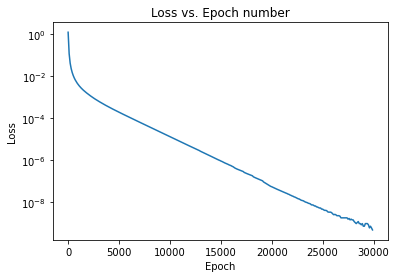

In [37]:
plt.plot(epoch_vec_adam, loss_vec_adam)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128172823/three_classes_adam_optimizer_final.ckpt


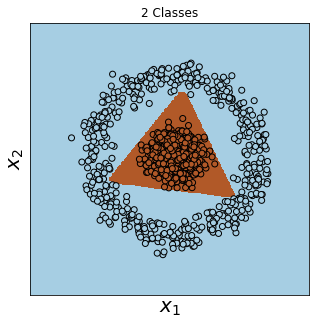

In [38]:
filenameGD = logdir+"three_classes_adam_optimizer_final.ckpt"

clf = MyMLP(filenameGD)

plot_decision_boundary(clf, X_, y_, '2 Classes')